In [1]:
from IPython.display import display, HTML # type:ignore
style = '<style> body { font-family: Oswald; font-size: 16px; } </style>'
display(HTML(style))

# <div style="font-family:'fantasy';">Ensemble Learning and Random Forest</div>
### <div style="font-family:'fantasy';">Ensemble Learning</div>
if we aggregate prediction of a group of predictors (such as classifiers) we often get better prediction than individual predictor that group of predictors is called ensemble and the technique is called ensemble learning.
### <div style="font-family:'fantasy';">random forest</div>
you can train decision trees on each random subset of of the training set. To make predictions we obtain the predictions of individual trees and predict the class that gets the most votes. Such an enemble is called random forest.
# <div style="font-family:'fantasy';">Voting classifiers</div>
supppose we have few classifiers each having around 80% accurracy. Simple way for a better classifier is to aggregate the predictions and predict the class with most votes. This is $hard \ voting \ classifier$. This achieves high accuracy. If there are sufficient number of individual classifiers present and each being however weak and they are diverse then their ensemble shall be strong learner.\
if you toss a coin with P(H) = 0.51 then the probability of getting heads as a majority increases with increase in the number of tosses(instances) as for majority using binomial coefficient,\
$
P(H>\frac{n}{2}) = P(\frac{n}{2})+P(\frac{n}{2}+1) ... P(n)\\
=^nC_{\frac{n}{2}}(0.51)^{\frac{n}{2}}\cdot(0.49)^{\frac{n}{2}}+^nC_{\frac{n}{2}+1}(0.51)^{\frac{n}{2}+1}\cdot(0.49)^{\frac{n}{2}-1}+...+^nC_n(0.5)^n\\
\text{ now at n=1000, }\\
P(H>501) = 75% \\
\text{now at n=10000, }\\
P(H>5001) = 97% \\
$\
Thus the ratio of heads apprach 51% with increse in n. 
On similar grounds on building an ensemble of 1000 classifiers each of 51% accuracy can lead to 75% accuracy. However the individual classifiers must be diverse and independent. This can be easily stated from the below diagram.\
This diagram shows a 10000 series of 10 tosses. What we can observe is that as the number of 10 tosses increases the heads ratio nearly approaches 51%


Text(0, 0.5, 'heads ratio')

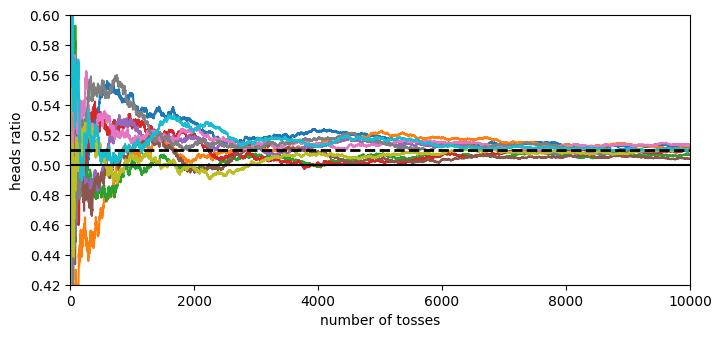

In [68]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int64)#generate random coin toss result 
cumulative_heads = coin_tosses.cumsum(axis=0)#generate the cumulative sum as in each series the elements will get added
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(10000,1)# generate the probability of head at each cumulative iteration
#note: that in the last step we divide by 10000 as we are fincing the cumulative results like we do in binomial probability distribution
# coin_tosses,cumulative_heads,cumulative_heads_ratio
# plotting the graph
plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlim(0,10000)
plt.ylim(0.42,0.6)
plt.xlabel("number of tosses")
plt.ylabel('heads ratio')

But in actual case as the classifier work on the same data they are prone to make same sort of errors so majority of votes go for the worng class, thus reducing the accuracy.\
Note: this works best if we train each model on different algorithms.


In [69]:
# making the dataset
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,train_size=0.8)

In [70]:
from sklearn.ensemble import VotingClassifier,RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
voting_clf = VotingClassifier(
    estimators=[
        ('log_clf',LogisticRegression(random_state=42)),
        ('svc',SVC(random_state=42)),
        ('rnd_clf',RandomForestClassifier(random_state=42))
    ]
)
voting_clf.fit(X_train,y_train)

VotingClassifier(estimators=[('log_clf', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('rnd_clf',
                              RandomForestClassifier(random_state=42))])

score calculation

In [71]:
for clf in voting_clf.named_estimators_.items():
    print(clf[0],clf[1].score(X_test,y_test))
print('voting_clf',voting_clf.score(X_test,y_test))

log_clf 0.85
svc 0.87
rnd_clf 0.88
voting_clf 0.87


In [72]:
#alternative checking using accuracy score
from sklearn.metrics import accuracy_score
for clf in voting_clf.named_estimators_.items():
    y_pred = clf[1].predict(X_test)
    print(clf[0],accuracy_score(y_test,y_pred))
print('voting_clf',accuracy_score(y_test,voting_clf.predict(X_test)))

log_clf 0.85
svc 0.87
rnd_clf 0.88
voting_clf 0.87


Now, there is another part to the voting classifier. If all classifiers are able to estimate class probabilities then sklearn can predict the class with highest class probability average over individual classifiers. This is called $soft \ voting \ classifier$. It often achieves higer performance because it gives more weight to highly confident votes. For SVC we can set ```probability=True```. This calculates probability using ```cross_val_scores``` but it will slow down slightly. 

In [73]:
voting_clf.voting='soft' # type: ignore
voting_clf.named_estimators['svc'].probability = True
voting_clf.fit(X_train,y_train)
voting_clf.score(X_test,y_test)

0.89

thus we can see there a subtle increment in the score by 2%.

# <div style="font-family:'fantasy';">Bagging and Pasting</div>
This is the approach saying train the same algo for every predictor but on different random subset of training data. When sampling is performed with replacement this is called **bagging**. If sampling is performed without replacement it is called **pasting**.\
Only bagging allows training instances to be sampled several times for same predictor(as sampling is performed with replacement).\
After training all the predictors ensemble can make prediction for a new instance by aggregating predictors of all prediction. This aggregation can be in the form of *hard voting* or average (*soft voting*). Each individual predictor has higher bias than if it were trained on original training set but aggregation reduces both bias and variance.

### <div style="font-family:'fantasy';">Bagging and Pasting in sklearn</div>

In [74]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)
bag_clf.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, random_state=42)

here ```n_estimators``` specifies the number of individual classifiers in the ensemble. \
```bootstrap``` is for bagging sampling or pasting. ```True``` means bagging and ```False``` means pasting.\
```n_jobs``` says how many cpu cores to be used -1 means it uses the default available cores. This is because this algorithm train the classifiers concurrently. This performs soft voting automatically if classifiers support generating class probabilities(or support ```predict_proba``` method).\
**ensembles have comparable bias but smaller variance**\
```bootstrap``` introduces more diversity in teh subsets that predictor is trained on. So bagging ends up with slightly more diversity that leads to better models.\
The following diagram shows the difference between using a single decision tree and an bagging ensemble of decision trees.


Text(0, 0.5, '')

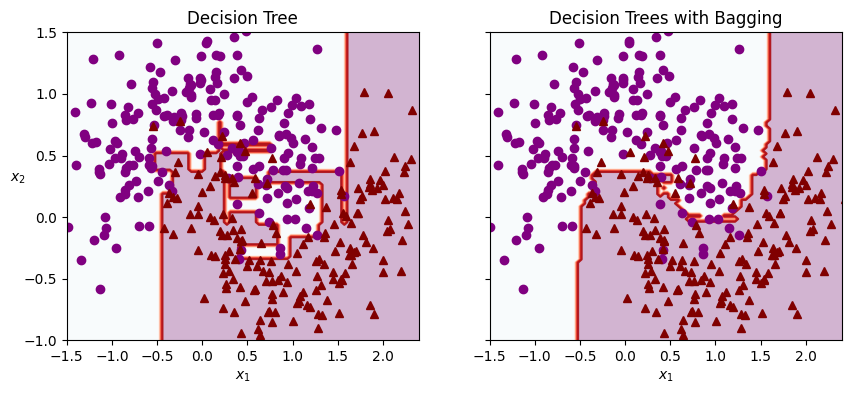

In [75]:
def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='BuPu')
    plt.contour(x1, x2, y_pred, cmap="Reds", alpha=0.8 * alpha)
    colors = ["purple", "maroon"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")

### <div style="font-family:'fantasy';">Out of bag evaluation</div>
By default for a baggin classifier with m instances if (m= training data size) then only 63% of the data are sampled on average for each predictor. Remaining 37% are out of bag for all predictors. Now oobs are not same for all predictors. As the predictor never sees oobs during training so it can be used as a testing or validating the predictor without needing separate validation set. We can evaluate the ensemble by averaging out oob evaluations. In sklearn we can set ```oob_score=True``` in the bagging classifier to request an automatic oob evaluation after training. This score can be checked through ```clf.oob_score_```. We can also see the oob decision function this will give probabilities of belonging to the class for each training instance. ```clf.oob_decision_function_```.

In [76]:
bag_clf.oob_score = True # type: ignore
bag_clf.fit(X_train,y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1, oob_score=True, random_state=42)

In [77]:
bag_clf.oob_score_

0.915

In [78]:
bag_clf.oob_decision_function_

array([[0.98670213, 0.01329787],
       [0.01066667, 0.98933333],
       [0.08974359, 0.91025641],
       [0.94670051, 0.05329949],
       [0.95886889, 0.04113111],
       [0.98994975, 0.01005025],
       [0.87002653, 0.12997347],
       [0.82479784, 0.17520216],
       [0.31524548, 0.68475452],
       [0.03768844, 0.96231156],
       [0.45454545, 0.54545455],
       [0.86683417, 0.13316583],
       [0.99744246, 0.00255754],
       [0.1425    , 0.8575    ],
       [0.47941889, 0.52058111],
       [0.93175853, 0.06824147],
       [0.97303922, 0.02696078],
       [0.99749373, 0.00250627],
       [0.84130982, 0.15869018],
       [0.2625    , 0.7375    ],
       [0.01578947, 0.98421053],
       [0.01842105, 0.98157895],
       [0.84343434, 0.15656566],
       [0.97022333, 0.02977667],
       [0.74603175, 0.25396825],
       [0.35356201, 0.64643799],
       [0.38560411, 0.61439589],
       [1.        , 0.        ],
       [0.01052632, 0.98947368],
       [0.02682927, 0.97317073],
       [0.

### <div style="font-family:'fantasy';">Random Patches and Random Subspaces</div>
used for random sampling of features rather than the instances by ```max_features``` and ```bootstrap_features```. Thus each predictor will be trained random subset of input set of features. This is useful when dealing with high dimensional input like image. Sampling both training instances and features are called random pathches. Similarly sampling just the features is called random subspaces.


# <div style="font-family:'fantasy';">Random forest</div>
This is the ensemble of decision trees generaly trained via bagging setting ```max_sample=m```
where m is the total number of instances

In [79]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
rnd_clf.fit(X_train,y_train)

RandomForestClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [80]:
y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.89

Randomforest classifier has all the hyperparameter of decision tree as well as bagging classifier. Random forest algo introduces extra randomness when growing trees instead of searching for the best feature while splitting node it searches best feature among the random subset of features. It results in greater diversity(thus increasing bias but reducing variance)
### <div style="font-family:'fantasy';">Extra trees</div>
At each node a random subset of features is considered for splitting and here we add more randomness by adding random thresholds for each feature rather than searching for the best possible threshold. This is extremely randomized Tree ensemble.\
It makes tree faster as we do not need to search for the best possible threshold.

In [81]:
from sklearn.ensemble import ExtraTreesClassifier
ext_clf = ExtraTreesClassifier(n_estimators=500,max_leaf_nodes=16,n_jobs=-1)
ext_clf.fit(X_train,y_train)


ExtraTreesClassifier(max_leaf_nodes=16, n_estimators=500, n_jobs=-1)

In [82]:
ext_clf.score(X_test,y_test)

0.91

as we can notice this gives the best score among all the ensembles till now 

### <div style="font-family:'fantasy';">Feature Importance</div>
sklearn measures feature importance by looking at how much the tree nodes that use that feature reduce the impurity on average. More precisely weighted average where the weight of each node is the number of samples associated with it.

In [83]:
# generating dataset
from sklearn.datasets import load_iris
import pandas as pd
iris = load_iris()
ft_train,ft_test,val_train,val_test = train_test_split(iris.data,iris.target) # type: ignore
iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [84]:
# training model
rnd_clf = RandomForestClassifier(n_estimators=500,random_state=42)
rnd_clf.fit(ft_train,val_train)

RandomForestClassifier(n_estimators=500, random_state=42)

In [85]:
for score, name in zip(rnd_clf.feature_importances_,iris.feature_names): # type: ignore
    print('{:.2}'.format(score),name)

0.11 sepal length (cm)
0.034 sepal width (cm)
0.47 petal length (cm)
0.38 petal width (cm)


below diagram shows the feature importance on a dataset with large number of features like mnist

In [86]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)



/home/icode100/pyenv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


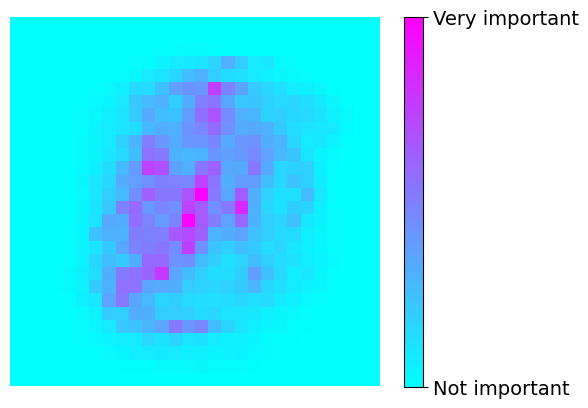

In [87]:
rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist) #type: ignore

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="cool")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

# <div style="font-family:'fantasy';">Boosting</div>
Refers to any ensemble method that can combine several weak learner into a strong learner.\
Train predictors sequentially each trying to correct its predecessor. It can be compared to evolution of species.

### <div style="font-family:'fantasy';">Adaptive Boosting(AdaBoosting)</div>
* current predictor corrects its predecessor by paying a bit more attention to the training instance that predecessor underfitted. This makes predictor focus more on the hard cases.
* algorithm trains abase classifier uses it to make prediction on training set. This algorithm then increases the realtive weight of misclassified training instances. Then second classifier uses the updated weights and makes predictions on the training set updates the weight and so on.
* once all predictors are trained ensemble makes prediction much like bagging and pasting excpt that predictions have different weights depending on their overall accuracy on weighted training set.
One drawback is that, it cannot be scaled as bagging as pasting as does not run parallely.\
Now, is m is the number of instances,\
each instance weight is initially set to $\frac{1}{m}$.\
predictor is trained and its weighted error rate $r_j$ is computed on the training set considering it is the $j^{th}$ predictor as,
$$
\text{equation 7-1 }\\
r_j = \frac{^{\sum_{i=1}^{m}w^{(i)}}_{\hat{y_j}^{(i)}\not=y^{(i)}}}{^{\sum_{i=1}^{m}w^{(i)}}}\\
$$
$\hat{y_j}^{(i)} \text{ is } j^{th} \text{ predictor's prediction of } i^{th} \text{ instance}$
Now the predictor's weight $\alpha_j$ is computed. More accurate the prediction is, higher the weight will be.
$$
\text{equation 7-2 }\\
\alpha_j = \eta \log_2{\frac{1-r_j}{r_j}}
$$
where $\eta$ is the learning rate.
$$
\text{equation 7-3 }\\
\begin{equation}
w^{(i)} = \begin{cases}
w^{(i)}, & \text{if } \hat{y_j}^{(i)}=y^{(i)}\\
w^{(i)}e^{\alpha_j}, & \text{if } \hat{y_j}^{(i)\not}=y^{(i)}\\
\end{cases}
\end{equation}
$$
where $w^{(i)}$ is the weight of the $i^{th}$ instance.\
After this all the weights are normalized by dividing by $\sum_{i=1}^{m}w^{(i)}$.\
Then the process repeats till a perfect predictor is found.\
AdaBoost simply computes the predictions of all predictors and weighs them using $\alpha_j$. The predicted class is the one that recieves majority of the weighted votes.
$$
\hat{y}(\vec{x}) = ^{\text{argmax}}_k \ ^{\sum_{j=1}^{N}\alpha_j}_{\hat{y}(\vec{x})=k}
$$
where N is the number of predictors.\
sklearn uses a version of SAMME(stagewise additive modelling using multiclass exponential loss function). If there are two class then it is same as adaBoost. If predictors can estimate class probabilities it uses SAMME.R(R for Real) this relies on class probabilities rather than predictions. Note that, $decision \ stump$ is a decision tree with ```max_depth=1```.\
below code show how to frame the adaBoost manually. Here we have trained 5 SVMs and plotted them for two differet learning rates\
below figure shows the two cases with different learning rates. This method is somewhat similar to GD except the fact that here we add predictors gradually making the prediction better.

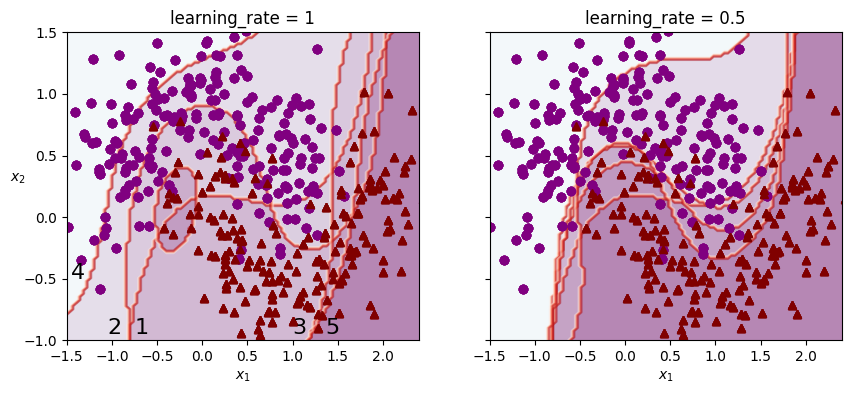

In [88]:
m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)

        error_weights = sample_weights[y_pred != y_train].sum()
        r = error_weights / sample_weights.sum()  # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r)  # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha)  # equation 7-3
        sample_weights /= sample_weights.sum()  # normalization step

        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.4)
        plt.title(f"learning_rate = {learning_rate}")
    if subplot == 0:
        plt.text(-0.75, -0.95, "1", fontsize=16)
        plt.text(-1.05, -0.95, "2", fontsize=16)
        plt.text(1.0, -0.95, "3", fontsize=16)
        plt.text(-1.45, -0.5, "4", fontsize=16)
        plt.text(1.36,  -0.95, "5", fontsize=16)
    else:
        plt.ylabel("")


Now we perform the same job using sklearn API

In [89]:
from sklearn.ensemble import AdaBoostClassifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm='SAMME.R',
    learning_rate=0.5
)
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

In [90]:
ada_clf.score(X_test,y_test)

0.89

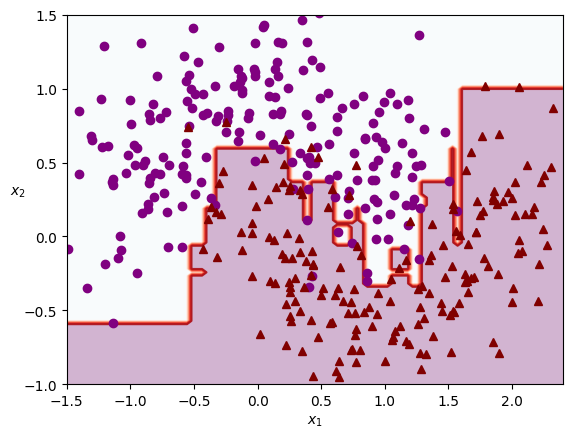

In [91]:
plot_decision_boundary(ada_clf, X_train, y_train)

### <div style="font-family:'fantasy';">Gradient Boosting</div>
This tries to fit new predictor to the residual errors made by previous predictor. Regression version of this is called $Gradient \ Boosted \ Regression \ Tree$ (GBRT).
Below is a manually drafted example.


In [92]:
#a noisy quadratic training set
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise

<div style="font-family:'PragmataPro';">training the first tree</div>

In [93]:
from sklearn.tree import DecisionTreeRegressor
tr1 = DecisionTreeRegressor(max_depth=2)
tr1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

<div style="font-family:'PragmataPro';">training the second tree on the residual errors made by the first tree</div>

In [94]:
tr2 = DecisionTreeRegressor(max_depth=2)
tr2.fit(X,y-tr1.predict(X))

DecisionTreeRegressor(max_depth=2)

<div style="font-family:'PragmataPro';">training the third tree on the residual errors made by the second tree</div>

In [95]:
tr3 = DecisionTreeRegressor(max_depth=2)
tr3.fit(X,y-tr1.predict(X)-tr2.predict(X))

DecisionTreeRegressor(max_depth=2)

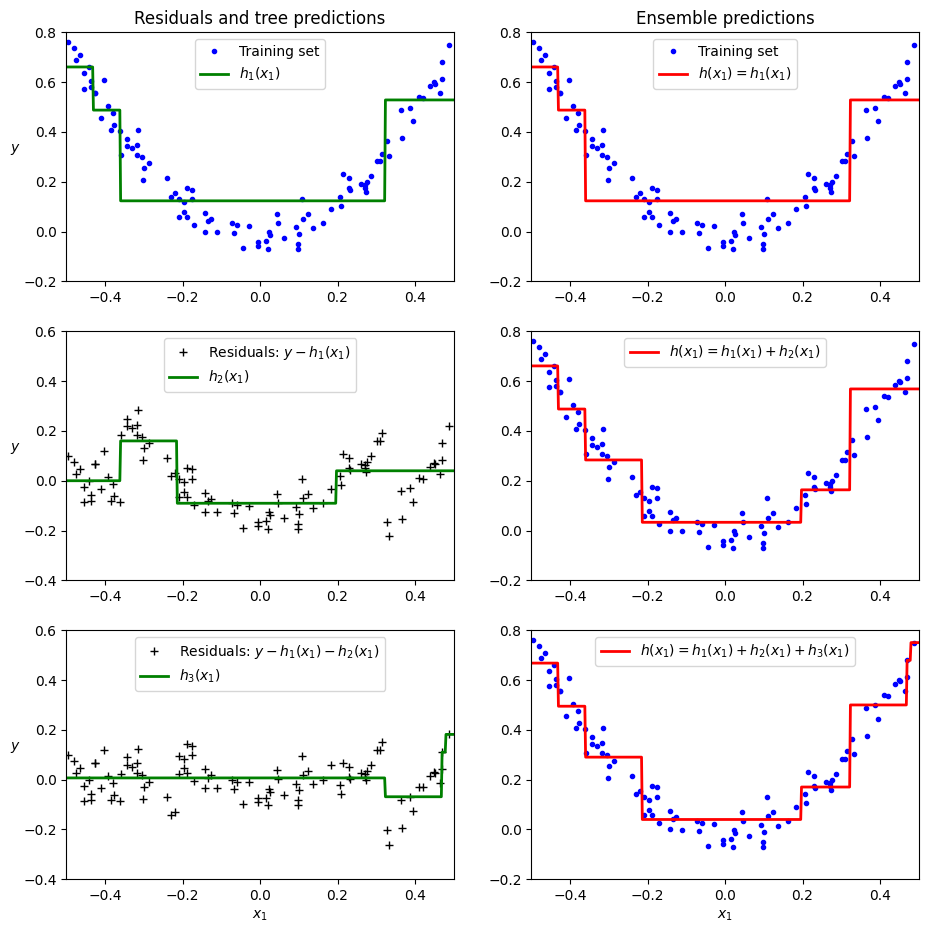

In [96]:
def plot_predictions(regressors, X, y, axes, style,
                     label=None, data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1))
                 for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center")
    plt.axis(axes)

plt.figure(figsize=(11, 11))

plt.subplot(3, 2, 1)
plot_predictions([tr1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="g-",
                 label="$h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$  ", rotation=0)
plt.title("Residuals and tree predictions")

plt.subplot(3, 2, 2)
plot_predictions([tr1], X, y, axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.title("Ensemble predictions")

plt.subplot(3, 2, 3)
plot_predictions([tr2], X, y-tr1.predict(X), axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_2(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1)$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 4)
plot_predictions([tr1, tr2], X, y, axes=[-0.5, 0.5, -0.2, 0.8],
                  style="r-", label="$h(x_1) = h_1(x_1) + h_2(x_1)$")

plt.subplot(3, 2, 5)
plot_predictions([tr3], X, y-tr1.predict(X)-tr2.predict(X), axes=[-0.5, 0.5, -0.4, 0.6], style="g-",
                 label="$h_3(x_1)$", data_style="k+",
                 data_label="Residuals: $y - h_1(x_1) - h_2(x_1)$")
plt.xlabel("$x_1$")
plt.ylabel("$y$  ", rotation=0)

plt.subplot(3, 2, 6)
plot_predictions([tr1, tr2, tr3], X, y,
                 axes=[-0.5, 0.5, -0.2, 0.8], style="r-",
                 label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$")


plt.show()

as you can see this is incremental the errors are reducing each step.
the diagram represents the predictions of the three trees in the left column, and the ensemble’s
predictions in the right column. In the first row, the ensemble has just one tree, so its predictions are
exactly the same as the first tree’s predictions. In the second row, a new tree is trained on the residual
errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the
predictions of the first two trees. Similarly, in the third row another tree is trained on the residual errors
of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to
the ensemble.\
we can also do the same thing using sklearn API.

In [97]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)  # y = 3x² + Gaussian noise


In [98]:
from sklearn.ensemble import GradientBoostingRegressor
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1.0,random_state=42)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

learining rate scales the contribution of each tree. If we setit low we will need more trees but it generalizes better. This regularization techniqueue is called *shrinkage*.

Now how to find the optimal number of trees for a given learning rate. We use the same concept that we used in stocastic gradient descent **early stopping**. The way for this is to use ```staged_predict```.Note that if we use simplyb predict then it will give the prediction by complete ensemble not the individual collection of trees at each stage. It returns an iterator over predictions made by the ensemble at each stage of training(with one tree, two tree, etc.). Below is the manual technique for the same. 

In [99]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
X_train,X_test,y_train,y_test = train_test_split(X,y)
gbrt = GradientBoostingRegressor(n_estimators=120,max_depth=2)
gbrt.fit(X_train,y_train)
errors = [mean_squared_error(y_test,y_pred) for y_pred in gbrt.staged_predict(X_test)] 
bst_n_estimators = np.argmin(errors)+1


In [100]:
gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators)
gbrt_best.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=80)

In [101]:
gbrt_best.score(X_test,y_test)

0.9558881570064862

Note that this is the best score till now 

In [102]:
gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=3,learning_rate=1,random_state=42)
gbrt.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3,
                          random_state=42)

Text(0.5, 0, '$x_1$')

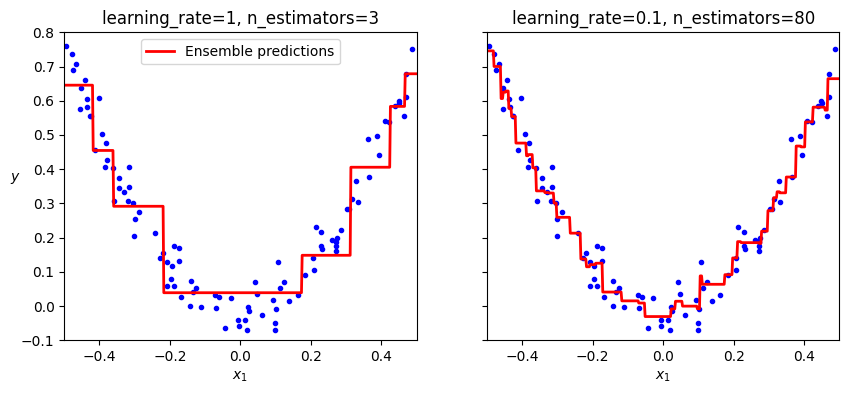

In [103]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-",
                 label="Ensemble predictions")
plt.title(f"learning_rate={gbrt.learning_rate}, "
          f"n_estimators={gbrt.n_estimators_}")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8], style="r-")
plt.title(f"learning_rate={gbrt_best.learning_rate}, "
          f"n_estimators={gbrt_best.n_estimators_}")
plt.xlabel("$x_1$")




Also we can make the ```warm_start = True``` making sklearn keep existing trees when the fit() is called allowing incremental training. 


In [104]:
gbrt = GradientBoostingRegressor(max_depth=2,warm_start=True)
min_val_error = float('inf')
error_going_up=0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test,y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up=0
    else:
        error_going_up+=1
        if error_going_up==5:
            break


In [105]:
gbrt.n_estimators_

59

# <div style="font-family:'fantasy';">Stacking</div>
Making a model that handles the voting of level predictors is stacking ensemble. It works like a chain rule. Instead of using some aggregate voting function we can use a separate model to predict the best among the votes of the first layer. This second layer is called blender.


In [108]:
from sklearn.ensemble import StackingClassifier
X,y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42,train_size=0.8)
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(probability=True, random_state=42))
    ],
    final_estimator=RandomForestClassifier(random_state=43),
    cv=5  # number of cross-validation folds
)
stacking_clf.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('lr', LogisticRegression(random_state=42)),
                               ('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42))],
                   final_estimator=RandomForestClassifier(random_state=43))

In [109]:
stacking_clf.score(X_test, y_test)

0.91

---
---
---